# Introduction

This notebook provides a quick description of how you can set up Gradient for use with [PyTorch Geometric](https://pytorch-geometric.readthedocs.io). After getting set up, you're encouraged to go explore whathever you find intriguing. 

# Setup

In [1]:
gradient=False

In [2]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
import shutil
import os, sys
import urllib
sys.path.append("../")

In [3]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

In [4]:
print(torch.__version__), print(torch.version.cuda)

1.8.1
11.1


(None, None)

In [5]:
if gradient:
    !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu110.html
    !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu110.html
    !pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cu110.html
    !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cu110.html
    !pip install torch-geometric
    !pip install scikit-learn

In [6]:
if gradient:
    DATA = Path('/storage/geometric')
    DATA.mkdir(exist_ok=True)
    TRANSFORMERS_CACHE=DATA/'cache'
else:
    DATA=Path('/home/alex/data-tmp/geometric')
    DATA.mkdir(exist_ok=True)

# Node classification with graph neural networks

This is based on the tutorial notebook [Node Classification with Graph Neural Networks](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX) of PyTorch Geometric which has many more details. 

It uses the benchmark data set `Citeseer`, [Yang et al. (2016)](https://arxiv.org/abs/1603.08861), [Giles et al. (1998)](https://clgiles.ist.psu.edu/papers/DL-1998-citeseer.pdf). It is a citation network where each node is a document and two nodes are connected if there is a citation link between them. The nodes are described by feature vectors based on [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model). 

The objective is to categorize the documents into one of 6 categories: 

In [7]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root=DATA/'Planetoid', name='Citeseer', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Citeseer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6

Data(edge_index=[2, 9104], test_mask=[3327], train_mask=[3327], val_mask=[3327], x=[3327, 3703], y=[3327])
Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Number of training nodes: 120
Training node label rate: 0.04
Contains isolated nodes: True
Contains self-loops: False
Is undirected: True


## Training a GNN using GCN layers

In [8]:
# Helper function for visualization.
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [9]:
from torch_geometric.nn import GCNConv

In [10]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [11]:
model = GCN(hidden_channels=16)
model

GCN(
  (conv1): GCNConv(3703, 16)
  (conv2): GCNConv(16, 6)
)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [13]:
def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

In [14]:
for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.7918
Epoch: 002, Loss: 1.7883
Epoch: 003, Loss: 1.7847
Epoch: 004, Loss: 1.7771
Epoch: 005, Loss: 1.7714
Epoch: 006, Loss: 1.7624
Epoch: 007, Loss: 1.7518
Epoch: 008, Loss: 1.7445
Epoch: 009, Loss: 1.7404
Epoch: 010, Loss: 1.7233
Epoch: 011, Loss: 1.7181
Epoch: 012, Loss: 1.7115
Epoch: 013, Loss: 1.6977
Epoch: 014, Loss: 1.6852
Epoch: 015, Loss: 1.6752
Epoch: 016, Loss: 1.6722
Epoch: 017, Loss: 1.6575
Epoch: 018, Loss: 1.6308
Epoch: 019, Loss: 1.6279
Epoch: 020, Loss: 1.6027
Epoch: 021, Loss: 1.6099
Epoch: 022, Loss: 1.5889
Epoch: 023, Loss: 1.5654
Epoch: 024, Loss: 1.5555
Epoch: 025, Loss: 1.5363
Epoch: 026, Loss: 1.5388
Epoch: 027, Loss: 1.5050
Epoch: 028, Loss: 1.5094
Epoch: 029, Loss: 1.4864
Epoch: 030, Loss: 1.4590
Epoch: 031, Loss: 1.4687
Epoch: 032, Loss: 1.4168
Epoch: 033, Loss: 1.3891
Epoch: 034, Loss: 1.4093
Epoch: 035, Loss: 1.3831
Epoch: 036, Loss: 1.3511
Epoch: 037, Loss: 1.3570
Epoch: 038, Loss: 1.3479
Epoch: 039, Loss: 1.3401
Epoch: 040, Loss: 1.2842


## Evaluate the results

In [15]:
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)

### Accuracy

In [16]:
test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
test_acc = int(test_correct.sum()) / int(data.test_mask.sum()) 
print(f'Test set accuracy: {test_acc}')

Test set accuracy: 0.715


### Confusion matrix

In [17]:
import sklearn

In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
from cm_utils import plot_confusion_matrix

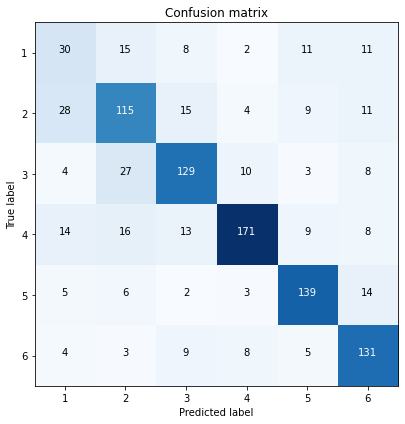

In [20]:
cm = confusion_matrix(data.y[data.test_mask], pred[data.test_mask])
plot_confusion_matrix(cm, classes=range(1,7))
plt.show()

### Visualize node clustering

We can take a look at how the nodes are clustered into the three categories after training:

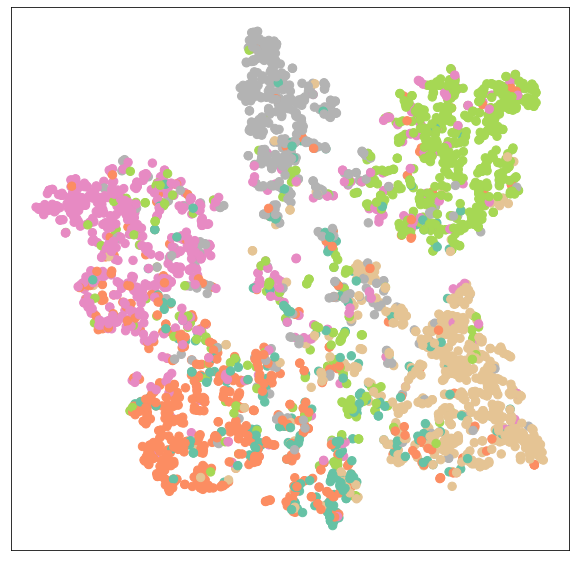

In [21]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)